<hr>
<h1 align="center"><b>Spatiotemporal Graph Neural Networks with <img src="https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/main/docs/source/_static/img/tsl_logo.svg" width="40px" align="center"/> tsl</b></h2>
<hr>

In this notebook, we will walk through the process of developing a **Spatiotemporal Graph Neural Network (STGNN)** for **traffic forecasting** using <img src="https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/main/docs/source/_static/img/tsl_logo.svg" width="30px" align="center"/> [**Torch Spatiotemporal (tsl)**](https://torch-spatiotemporal.readthedocs.io/), a Python library specifically designed for **neural spatiotemporal data processing**.

**Torch Spatiotemporal** builds upon popular libraries in the Python scientific ecosystem, such as [PyTorch](https://pytorch.org/), [PyTorch Geometric (PyG)](https://pyg.org/), and [PyTorch Lightning](https://www.pytorchlightning.ai/). It simplifies the workflow for tasks involving **time series with relational information**, including preprocessing, model development, and evaluation.

By the end of this tutorial, you will:

1. Understand the core features of `tsl` for **spatiotemporal data processing**.
2. Learn how to create a **custom STGNN model** using `tsl`.
3. Explore practical steps for **traffic forecasting** on a real-world dataset, showcasing a key application where graphs improve time series forecasting.

<hr>

# **Quickstart**

<hr>

## Installation
<hr>

Let's start by installing tsl from GitHub, to be up-to-date with the latest version.

Note that tsl must be installed in a Python environment with Pytorch and PyG.

In [2]:
import sys
import platform

print("--- 專案環境 Python 版本 ---")
print(f"Python 主版本: {sys.version.split(' ')[0]}")
print(f"Python 版本資訊: {sys.version}")
print(f"系統架構: {platform.platform()}")

print("---------------------------")

--- 專案環境 Python 版本 ---
Python 主版本: 3.11.14
Python 版本資訊: 3.11.14 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 18:30:03) [MSC v.1929 64 bit (AMD64)]
系統架構: Windows-10-10.0.26100-SP0
---------------------------


In [ ]:
# Install required packages.
import os
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # True 表示 GPU 可用

import torch_geometric
print(torch_geometric.__version__)

2.5.1+cu121
True


c:\Users\user\anaconda3\envs\gnnwork\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.7.0


In [2]:
"""
!pip install -U pandas==2.0
!pip install -U torch
"""

'\n!pip install -U pandas==2.0\n!pip install -U torch\n'

In [3]:
"""
# Install tsl from source
!pip install -q git+https://github.com/TorchSpatiotemporal/tsl.git 
"""

'\n# Install tsl from source\n!pip install -q git+https://github.com/TorchSpatiotemporal/tsl.git \n'

In [ ]:
"""
# Install PyG dependencies
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html  # 稀疏矩陣操作，尤其是在圖資料處理中常見的聚合(Aggregation) 步驟，以高效處理大型稀疏圖。
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html   # 高效能地處理稀疏張量，是圖神經網路(GNN)計算的核心，例如處理連接矩陣。
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git       # 提供大量GNN模型、層和實用的資料結構，讓你可以在PyTorch中輕鬆建立和訓練處理圖結構資料的模型。

# Install tsl from source
!pip install -q git+https://github.com/TorchSpatiotemporal/tsl.git        # 用於處理時空圖資料（例如交通、天氣等），提供標準化的資料集載入、預處理和 STGNN 模型的開發流程。
"""

2.5.1+cu121


'\n# Install PyG dependencies\n!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html  # 稀疏矩陣操作，尤其是在圖資料處理中常見的聚合(Aggregation) 步驟，以高效處理大型稀疏圖。\n!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html   # 高效能地處理稀疏張量，是圖神經網路(GNN)計算的核心，例如處理連接矩陣。\n!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git       # 提供大量GNN模型、層和實用的資料結構，讓你可以在PyTorch中輕鬆建立和訓練處理圖結構資料的模型。\n\n# Install tsl from source\n!pip install -q git+https://github.com/TorchSpatiotemporal/tsl.git        # 用於處理時空圖資料（例如交通、天氣等），提供標準化的資料集載入、預處理和 STGNN 模型的開發流程。\n'

We refer to [tsl](https://torch-spatiotemporal.readthedocs.io/en/latest/usage/quickstart.html) and [PyG](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) installation guidelines for the setup in other environments.

Let's check if everything is ok.

In [5]:
"""
!wget -q --show-progress -O notebook_utils.py https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/refs/heads/dev/examples/notebooks/_notebook_utils.py
"""

'\n!wget -q --show-progress -O notebook_utils.py https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/refs/heads/dev/examples/notebooks/_notebook_utils.py\n'

In [6]:
"""
import urllib.request

url = "https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/refs/heads/dev/examples/notebooks/_notebook_utils.py"
urllib.request.urlretrieve(url, "notebook_utils.py")
print("下載完成")
"""

'\nimport urllib.request\n\nurl = "https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/refs/heads/dev/examples/notebooks/_notebook_utils.py"\nurllib.request.urlretrieve(url, "notebook_utils.py")\nprint("下載完成")\n'

#### 確認版本都正確

In [3]:
import tsl
import torch
import torch_geometric
import numpy as np
import pandas as pd
from notebook_utils import *

print(f"torch version: {torch.__version__}")
print(f"  PyG version: {torch_geometric.__version__}")
print(f"  tsl version: {tsl.__version__}")

torch version: 2.5.1+cu121
  PyG version: 2.7.0
  tsl version: 0.9.6


## Usage
<hr>

The functionality of <img src="https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/main/docs/source/_static/img/tsl_logo.svg" width="25px" align="center"/> tsl can be categorized into two major components:

1. **Data Loading and Preprocessing**  
   Modules that simplify handling and preparing spatiotemporal data for machine learning models, including:
   - **Scaling and normalization**
   - **Resampling and clustering**
   - **Handling irregularities and missing data**

2. **Modeling and Inference**  
   A suite of tools for designing and training spatiotemporal models, including:
   - Specialized **neural layers** for spatiotemporal tasks.
   - Pre-built and customizable **engines** for tasks like forecasting and imputation.

We will go deeper into each of these components in the following sections, starting with an overview of data loading and preprocessing.


<hr>

# **Loading and Preprocessing Data**

<hr>

## Loading a tabular dataset
<hr>

<img src="https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/main/docs/source/_static/img/tsl_logo.svg" width="25px" align="center"/> tsl comes with a variety of datasets popular in literature. You can find them inside the submodule [`tsl.datasets`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets.html).

In [4]:
from tsl import datasets
print("Datasets in tsl:", *datasets.dataset_classes, sep='\n- ')

Datasets in tsl:
- AirQuality
- Elergone
- EngRad
- MetrLA
- PemsBay
- PeMS03
- PeMS04
- PeMS07
- PeMS08
- LargeST
- PvUS
- ElectricityBenchmark
- TrafficBenchmark
- SolarBenchmark
- ExchangeBenchmark
- GaussianNoiseSyntheticDataset
- GPVARDataset
- GPVARDatasetAZ


As an example, we will use the [MetrLA](https://paperswithcode.com/sota/traffic-prediction-on-metr-la) dataset, a widely used benchmark for traffic forecasting. This dataset consists of traffic speed readings from 207 loop detectors on highways in Los Angeles County, aggregated at 5-minute intervals over a span of 4 months (March to June 2012).

Loading the dataset is as simple as that:

In [5]:
from tsl.datasets import MetrLA

dataset = MetrLA(root='./data')

print(dataset)

MetrLA(length=34272, n_nodes=207, n_channels=1)


All the datasets in tsl are subclass of the root class [`tsl.datasets.Dataset`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets_prototypes.html#tsl.datasets.prototypes.Dataset), exposing useful APIs for spatiotemporal datasets. We can see that data are organized a 3-dimensional array, with:

* **34.272** time steps (1 each 5 minute for 4 months)
* **207** nodes (the loop detectors)
* **1** channels (detected speed)

Nice! Other than storing the data of interest, the dataset comes with useful tools.

In [6]:
print(f"Sampling period: {dataset.freq}")
print(f"Has missing values: {dataset.has_mask}")
print(f"Percentage of missing values: {(1 - dataset.mask.mean()) * 100:.2f}%")
print(f"Has exogenous variables: {dataset.has_covariates}")
print(f"Covariates: {', '.join(dataset.covariates.keys())}")

Sampling period: <5 * Minutes>
Has missing values: True
Percentage of missing values: 8.11%
Has exogenous variables: True
Covariates: dist


Let's look at the output. We know that the dataset has missing entries, with `dataset.mask` being a binary indicator associated with each timestep, node and channel (with ones indicating valid values).

Also, the dataset has a **covariate** attribute (i.e., exogenous variables) – the distance matrix – containing the pairwise distances between sensors.

You can access covariates by `dataset.{covariate_name}`:

In [7]:
print_matrix(dataset.dist)

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,0.00,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,3764.70,inf,inf,9204.30,inf,inf,8114.80,10009.70
1,inf,0.00,2504.60,8563.80,8572.50,9561.00,9590.00,2506.30,inf,inf,...,inf,inf,inf,inf,4941.90,7559.20,7877.20,inf,inf,inf
2,inf,1489.30,0.00,6971.30,6978.30,9148.20,9177.10,3995.70,inf,inf,...,inf,9467.80,inf,inf,6431.40,7821.80,9366.60,inf,inf,9837.00
3,inf,6805.90,9293.60,0.00,1745.50,6068.80,5401.50,9312.30,inf,inf,...,inf,5906.50,inf,inf,inf,inf,inf,inf,inf,7604.40
4,inf,6606.70,9111.30,1767.40,0.00,4464.00,3655.90,9113.10,inf,inf,...,inf,7207.10,inf,inf,inf,inf,inf,inf,inf,8905.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,inf,inf,10987.10,inf,inf,inf,inf,10133.60,inf,inf,...,inf,inf,inf,inf,9098.90,0.00,4072.70,inf,inf,inf
203,inf,10723.20,9461.80,inf,inf,inf,inf,8608.30,inf,inf,...,inf,inf,inf,inf,7283.50,inf,0.00,inf,inf,inf
204,inf,inf,inf,inf,inf,inf,inf,inf,9189.80,3171.10,...,3672.40,inf,inf,inf,inf,inf,inf,0.00,inf,inf
205,9599.80,inf,inf,inf,inf,inf,inf,inf,inf,10167.50,...,inf,inf,10500.80,inf,inf,inf,inf,inf,0.00,inf


This matrix stores the pairwise distance between sensors, with `inf` denoting two non-neighboring sensors.

Let's now check how the speed readings look like.

In [8]:
dataset.dataframe()

nodes,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
channels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-03-01 00:00:00,64.38,67.62,67.12,61.50,66.88,68.75,65.12,67.12,59.62,62.75,...,45.62,65.50,64.50,66.43,66.88,59.38,69.00,59.25,69.00,61.88
2012-03-01 00:05:00,62.67,68.56,65.44,62.44,64.44,68.11,65.00,65.00,57.44,63.33,...,50.67,69.88,66.67,58.56,62.00,61.11,64.44,55.89,68.44,62.88
2012-03-01 00:10:00,64.00,63.75,60.00,59.00,66.50,66.25,64.50,64.25,63.88,65.38,...,44.12,69.00,56.50,59.25,68.12,62.50,65.62,61.38,69.86,62.00
2012-03-01 00:15:00,64.00,63.75,60.00,59.00,66.50,66.25,64.50,64.25,63.88,65.38,...,44.12,69.00,56.50,59.25,68.12,62.50,65.62,61.38,69.86,62.00
2012-03-01 00:20:00,64.00,63.75,60.00,59.00,66.50,66.25,64.50,64.25,63.88,65.38,...,44.12,69.00,56.50,59.25,68.12,62.50,65.62,61.38,69.86,62.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-27 23:35:00,65.00,65.89,68.56,61.67,32.83,54.56,62.44,63.33,59.22,65.33,...,52.89,69.00,65.11,55.67,66.33,62.44,66.78,64.89,69.67,62.33
2012-06-27 23:40:00,61.38,65.62,66.50,62.75,32.83,50.50,62.00,67.00,65.25,67.12,...,54.00,69.25,60.12,60.50,67.25,59.38,66.00,61.25,69.00,62.00
2012-06-27 23:45:00,67.00,59.67,69.56,61.00,32.83,44.78,64.22,63.78,59.78,57.67,...,51.33,67.89,64.33,57.00,66.00,62.67,68.67,63.33,67.44,61.22


### Connecting sensors

Besides the time series, to properly use graph-based models, we need to __connect__ nodes somehow.

With the method [`dataset.get_similarity()`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets_prototypes.html#tsl.datasets.prototypes.Dataset.get_similarity) we can retrieve nodes' similarities computed with different methods. The available similarity methods for a dataset can be found at `dataset.similarity_options`, while the default one is at `dataset.similarity_score`.

In [ ]:
print(f"Default similarity: {dataset.similarity_score}")
print(f"Available similarity options: {dataset.similarity_options}")
print("==========================================")

sim = dataset.get_similarity("distance")  # or dataset.compute_similarity()

print("Similarity matrix W:")
print_matrix(sim)

Default similarity: distance
Available similarity options: {'distance'}
Similarity matrix W:


,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.39,0.00,0.00,0.00,0.00,0.39,0.00,0.00,...,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00
2,0.00,0.72,1.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,1.00,0.63,0.00,0.01,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.63,1.00,0.05,0.14,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.08,0.00,0.00,0.00
203,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,...,0.13,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
205,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


通過計算的節點相似度，我們可以發現使用distance來連接節點是比較好的選擇，也計算出distance的Similarity matrix W。

With this method, we compute weight $w_t^{i,j}$ of the edge connecting $i$-th and $j$-th node as<br>
$$
w^{i,j} = \left\{\begin{array}{cl}
     \exp \left(-\frac{\operatorname{dist}\left(i, j\right)^{2}}{\gamma}\right) & \operatorname{dist}\left(i, j\right) \leq \delta  \\
     0 & \text{otherwise}
\end{array}\right. ,
$$<br>
where $\operatorname{dist}\left(i, j\right)$ is the distance between $i$-th and $j$-th node, $\gamma$ controls the kernel width and $\delta$ is a threshold. Notice that in this case the similarity matrix is not symmetric, since the original preprocessed distance matrix is not symmetric too.

So far so good, now we can build an adjacency matrix out ouf the computed similarity.

The method [`dataset.get_connectivity()`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets_prototypes.html#tsl.datasets.prototypes.Dataset.get_connectivity) – calling `dataset.get_similarity()` under-the-hood – provides useful preprocessing options, and, eventually, returns a possibly sparse, possibly weighted, adjacency matrix.

In [ ]:
# 計算的節點相似度，最終傳回一個可能稀疏、可能加權的鄰接矩陣。
connectivity = dataset.get_connectivity(threshold=0.1,
                                        include_self=False,
                                        normalize_axis=1,
                                        layout="edge_index")

Let's see what happens with this function call:

1. compute the similarity matrix as before;
1. set to 0 values **below** 0.1 (`threshold=0.1`);
1. **remove** self loops (`include_self=False`);
1. **normalize** edge weights by the **in degree** of nodes (`normalize_axis=1`);
1. request the sparse **COO layout** of PyG (`layout="edge_index"`)

The connectivity matrix with `edge_index` layout is provided in COO format, adopting the convention and notation used in PyTorch Geometric. The returned connectivity is a tuple (`edge_index`, `edge_weight`), where `edge_index` lists all edges as pairs of source-target nodes (dimensions `[2, E]`) and `edge_weight` (dimension `[E]`) stores the corresponding weights.

In [ ]:
# 提取 edge_index 和 edge_weight
edge_index, edge_weight = connectivity

print(f'edge_index {edge_index.shape}:\n', edge_index)
print(f'edge_weight {edge_weight.shape}:\n', edge_weight)

edge_index (2, 1515):
 [[  0   0   0 ... 206 206 206]
 [ 13  36  58 ... 157 162 198]]
edge_weight (1515,):
 [0.08  0.163 0.031 ... 0.045 0.031 0.115]


The `"dense"` layout instead corresponds to the weighted adjacency matrix $A \in \mathbb{R}^{N \times N}$. The module [`tsl.ops.connectivity`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/ops.html#module-tsl.ops.connectivity) contains useful operations for connectivities, including methods to change layout.

In [ ]:
from tsl.ops.connectivity import edge_index_to_adj

# 從 edge_index 和 edge_weight 重建鄰接矩陣
adj = edge_index_to_adj(edge_index, edge_weight)
print(f'A {adj.shape}:')
print_matrix(adj)

A (207, 207):


,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.14,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.11,0.00,0.00,0.02,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
203,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,...,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
205,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


From the dense layout, the sparse COO format can be easily retrieved as:

In [13]:
print(f'Sparse edge weights:\n', adj[edge_index[1], edge_index[0]])

Sparse edge weights:
 [0.08  0.163 0.031 ... 0.045 0.031 0.115]


## Building a PyTorch-ready dataset
<hr>

In this section, we will see how to fetch **spatiotemporal graph signals** that are then given as input to a neural network (e.g., an STGNN) starting from a dataset of this kind.

The first class that comes in help is [`tsl.data.SpatioTemporalDataset`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_pytorch_datasets.html#tsl.data.SpatioTemporalDataset). This class is a subclass of [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and is in charge of mapping a tabular dataset represented in your preferred format (e.g., numpy array, pandas dataframe or the aforementioned [`tsl.datasets.Dataset`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets_prototypes.html#tsl.datasets.prototypes.Dataset)) to a PyTorch-ready implementation.

In particular, a `SpatioTemporalDataset` object can be used to achieve the following:
* Perform **data manipulation** operations required to feed the data to a PyTorch module (e.g., casting data to `torch.tensor`, handling possibly different `shapes`, synchronizing temporal data).
* Create **`(input, target)` samples** for supervised learning following the [**sliding window**](https://torch-spatiotemporal.readthedocs.io/en/latest/usage/spatiotemporal_dataset.html#sliding-window) approach.
* Define how data should be **arranged** in a **spatiotemporal graph signal** (e.g.,  which are the inputs and targets, how node attributes and covariates variables are mapped into a single graph).
* **Preprocess** data before creating a **spatiotemporal graph signal** by appling [**transformations**](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/transforms.html) or [**scaling**](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_preprocessing.html) operations.

Let's see how to go from a `Dataset` to a `SpatioTemporalDataset`.

In [ ]:
from tsl.data import SpatioTemporalDataset

from tsl.data import SpatioTemporalDataset

torch_dataset = SpatioTemporalDataset(target=dataset.dataframe(), # 核心資料：時空時間序列數據
                                      connectivity=connectivity,  # 圖結構：節點之間的連接矩陣 (或稱鄰接矩陣)，定義空間關係。
                                      mask=dataset.mask,          # 資料遮罩：用於標記資料中的缺失值 (Missing Values) 或無效值。
                                      horizon=12,                  # 預測未來長度：設定模型需要預測未來 12 個時間步。
                                      window=12,                  # 歷史輸入窗口：設定模型觀察過去 12 個時間步的數據作為輸入。
                                      stride=1)                   # 滑動步長：設定窗口每次移動 1 個時間步來切分樣本，確保生成最多的訓練樣本。

print(torch_dataset)

SpatioTemporalDataset(n_samples=34249, n_nodes=207, n_channels=1)


MetrLA(length=34272, n_nodes=207, n_channels=1)  vs  SpatioTemporalDataset(n_samples=34249, n_nodes=207, n_channels=1)

由於window and stride影響原始樣本分割所導致!


As you can see, the number of samples is not the same as the number of steps we have in the dataset. Indeed, we divided the historic time series with a **sliding window** of **12 time steps** for the **lockback window** (`window=12`), with a corresponding **horizon** of **12 time steps** (`horizon=12`). Thus, a single sample spans for a total of 24 time steps. The `stride` parameters set how many time steps intercurring between two subsequent samples. The following picture helps at visualizing how these (and more) parameters affect the slicing of the original time series in samples.

<p align="center">
  <img src="https://torch-spatiotemporal.readthedocs.io/en/latest/_images/sliding_window.svg" width="500em">
</p>

## Spatiotemporal graph signals in tsl

We now have a PyTorch-based dataset containing a collection of spatiotemporal graph signals. We can fetch samples in the same way we fetch elements of a Python list. Let's look in details to the layout of a sample:

In [15]:
sample = torch_dataset[0]
print(sample)

Data(
  input=(x=[t=12, n=207, f=1], edge_index=[2, e=1515], edge_weight=[e=1515]),
  target=(y=[t=12, n=207, f=1]),
  has_mask=True
)


A sample is of type [`tsl.data.Data`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_objects.html#tsl.data.Data), the base class for representing spatiotemporal graph signals in tsl. This class extends [`torch_geometric.data.Data`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data), preserving all its functionalities and
adding utilities for spatiotemporal data processing. The main APIs of `Data` include:

* **`Data.input`**: view on the tensors stored in `Data` that are meant to serve as input to the model.
  In the simplest case of a single node-attribute matrix, we could just have `Data.input.x`.
* **`Data.target`**: view on the tensors stored in `Data` used as labels to train the model.
  In the common case of a single label, we could just have `Data.input.y`.
* **`Data.edge_index`**: graph connectivity in COO format (i.e., as node pairs).
* **`Data.edge_weight`**: weights of the graph connectivity, if any.
* **`Data.mask`**: binary mask indicating the data in `Data.target.y` to be used as ground-truth for the loss (default is `None`).
* **`Data.transform`**: mapping of `ScalerModule`, whose keys must be
  transformable (or transformed) tensors in `Data`.
* **`Data.pattern`**: mapping containing the *pattern* for each tensor in `Data`. Patterns add information about the dimensions of tensors (e.g., specifying which are the time step and node dimensions).

None of these attributes are required and custom attributes can be seamlessly added.

Let's check more in details how each of these attributes is composed.

#### Input and Target

`Data.input` and `Data.target` provide a **view** on the unique (shared) storage in `Data`, such that the same key in `Data.input` and `Data.target` cannot reference different objects.

In [16]:
sample.input.to_dict()

{'x': tensor([[[64.375],
          [67.625],
          ...,
          [69.000],
          [61.875]],
 
         [[62.667],
          [68.556],
          ...,
          [68.444],
          [62.875]],
 
         ...,
 
         [[65.222],
          [63.667],
          ...,
          [67.222],
          [60.000]],
 
         [[62.250],
          [67.750],
          ...,
          [66.500],
          [59.429]]]),
 'edge_index': tensor([[  0,   0,  ..., 206, 206],
         [ 13,  36,  ..., 162, 198]]),
 'edge_weight': tensor([0.080, 0.163,  ..., 0.031, 0.115])}

In [17]:
sample.target.to_dict()

{'y': tensor([[[61.125],
          [67.000],
          ...,
          [70.000],
          [63.500]],
 
         [[58.556],
          [62.667],
          ...,
          [66.222],
          [62.333]],
 
         ...,
 
         [[63.222],
          [64.111],
          ...,
          [67.333],
          [63.000]],
 
         [[65.000],
          [63.000],
          ...,
          [64.125],
          [60.750]]])}

#### Mask and Transform

`mask` and `transform` are just symbolic links to the corresponding object inside the storage. They also expose properties `has_mask` and `has_transform`.

In [18]:
if sample.has_mask:
    print(sample.mask)
else:
    print("Sample has no mask.")

tensor([[[True],
         [True],
         ...,
         [True],
         [True]],

        [[True],
         [True],
         ...,
         [True],
         [True]],

        ...,

        [[True],
         [True],
         ...,
         [True],
         [True]],

        [[True],
         [True],
         ...,
         [True],
         [True]]])


In [19]:
if sample.has_transform:
    print(sample.transform)
else:
    print("Sample has no transformation functions.")

Sample has no transformation functions.


#### Pattern

The `pattern` mapping can be useful to glimpse on how data are arranged.
The convention we use is the following:

* `'t'` stands for the **time steps** dimension
* `'n'` stands for a **node** dimension
* `'e'` stands for the **edge** dimension
* `'f'` stands for a **feature** dimension
* `'b'` stands for the **batch** dimension


In [20]:
print(sample.pattern)
print("==================   Or we can print patterns and shapes together   ==================")
print(sample)

{'x': 't n f', 'mask': 't n f', 'edge_index': '2 e', 'edge_weight': 'e', 'y': 't n f'}
==================   Or we can print patterns and shapes together   ==================
Data(
  input=(x=[t=12, n=207, f=1], edge_index=[2, e=1515], edge_weight=[e=1515]),
  target=(y=[t=12, n=207, f=1]),
  has_mask=True
)


## Batching spatiotemporal graph signals

Getting a batch of spatiotemporal graph signals from a single dataset is as simple as accessing multiple elements from a list:

In [21]:
batch = torch_dataset[:5]
print(batch)

StaticBatch(
  input=(x=[b=5, t=12, n=207, f=1], edge_index=[2, e=1515], edge_weight=[e=1515]),
  target=(y=[b=5, t=12, n=207, f=1]),
  has_mask=True
)


As you can see, we now have an additional dimension for the time-varying elements (i.e., `x` and `y`) denoted by pattern `b`, i.e., the batch dimension. In this new, first dimension we stacked the features of the first 5 spatiotemporal graphs in the dataset.

Note that this is possible only because we are assuming a fixed underlying topology, as also confirmed by the `edge_index` and `edge_weight` attributes. The explanation on how `Data` objects with different graphs are batched together is out of the scope of this notebook.

## Preparing the dataset for training
<hr>

Usually, before running an experiment there are two quite common preprocessing steps:

* **splitting** the dataset into **training/validation/test** sets;
* **data preprocessing** (scaling/normalizing data, detrending).

In tsl, these operations are managed by the [`tsl.data.SpatioTemporalDataModule`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_datamodule.html#tsl.data.datamodule.SpatioTemporalDataModule), which is based on the [`LightningDataModule`](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.core.LightningDataModule.html#pytorch_lightning.core.LightningDataModule) from [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/). A `DataModule` allows us to standardize and make consistent the training, validation, test splits, data preparation and transformations across different environments and experiments.

Let's see an example

In [ ]:
print(type(torch_dataset))
print(len(torch_dataset))  # 確認 dataset 非空，並且長度至少要大於 train+val+test。

<class 'tsl.data.spatiotemporal_dataset.SpatioTemporalDataset'>
34249


In [ ]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
from tsl.data.preprocessing import StandardScaler

# Normalize data using mean and std computed over time and node dimensions
scalers = {'target': StandardScaler(axis=(0, 1))}

# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

# 建立 DataModule，按照定義的 dataset, scalers, splitter 進行初始化。
dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=64,
)

You can consider to extend the base `SpatioTemporalDataModule` to add further processing to fit your needs.

At this point, the `DataModule` object has not actually performed any processing yet (lazy approach).

We can execute the preprocessing routines by calling the `dm.setup()` method.

In [27]:
# 執行資料集的切割 (splitter) 和資料的標準化 (scalers)，並在內部準備好訓練、驗證和測試用的 DataLoader。
dm.setup()
print(dm)

{Train dataloader: size=24648}
{Validation dataloader: size=2728}
{Test dataloader: size=6849}
{Predict dataloader: None}


During `setup` the datamodule does the following operations:

1. Carries out the dataset splitting into training/validation/test sets according to the provided [`Splitter`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_datamodule.html#tsl.data.datamodule.splitters.Splitter).
1. Fits all the `Scalers` on the training data in `torch_dataset` corresponding to the scalers' key.

### Splitters

Splitters in tsl are the objects defining the policy of data splitting. [Read more](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_datamodule.html#splitters)

### Scalers

The `tsl.data.preprocessing` package offers several of the most common data normalization techniques under the `tsl.data.preprocessing.Scaler` interface.
They adopt an API similar to `scikit-learn`'s scalers, with `fit`/`transform`/`fit_transform`/`inverse_transform` methods. [Read more](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_preprocessing.html#scalers)

<hr>

# **Building Spatiotemporal Graph Neural Networks**

<hr>

In this section, we will see how to build a very simple  Spatiotemporal Graph Neural Network.

All the functions and classes needed to build neural networks in tsl are under the [`tsl.nn`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn.html) module.


## The `nn` module
<hr>

The [`tsl.nn`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn.html) module is organized as follows:

```
tsl
└── nn
    ├── base
    ├── blocks
    ├── layers
    └── models
```

The 3 most important submodules in it are [`layers`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn_layers.html), [`blocks`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn_blocks.html), and [`models`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn_models.html), ordered by increasing level of abstraction.

### Layers
(層) — 最基本的運算單元

A **layer** is a basic building block for our neural networks. In simple words, a layer takes an input, performs one (or few) operations, and returns a transformation of the input. Examples of layers are [`DiffConv`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn_layers.html#tsl.nn.layers.graph_convs.DiffConv), which implements the [diffusion convolution](https://arxiv.org/abs/1707.01926) operation, or [`LayerNorm`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn_layers.html#tsl.nn.layers.norm.LayerNorm).

### Blocks
(區塊) — 更複雜的轉換或功能單元(多個 layers 或更複雜的操作組合起來，ex: encoders & decoders。)

**blocks** perform more complex transformations or combine several operations. We divide blocks into **encoders**, if they provide a representation of the input in a new space, and **decoders**, if they produce a meaningful output from a representation.

### Models
(模型) — 完整的網路架構(多個 blocks 和/或 layers 包裝組合起來)

We wrap a series of operations, represented by blocks and/or layers, in a **model**. A model takes as input a spatiotemporal graph signal and returns the desired output, e.g., the forecasted node features at future time steps.

## Designing a custom STGNN
<hr>

Let's get the hands dirty and create our first simple STGNN! We will follow the **Time-then-Space** paradigm. We use a GRU shared among the nodes to process the temporal dimension. This will give us in output a single feature vector for each node, which is then propagated through the underlying graph using a Diffusion Convolutional GNN. Before and after, we add linear transformations to encode the input features and decode the learned representations. We also make use of **node embeddings** (free parameters learned individually for each node) to make our STGNN a **global-local model** ([Cini et al., 2023](https://arxiv.org/abs/2302.04071)).

All the layers that we need are provided inside `tsl.nn`. We use:
* [`RNN`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn_blocks.html#tsl.nn.blocks.encoders.RNN) from `tsl.nn.blocks.encoders` for the GRU;
* [`DiffConv`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn_layers.html#tsl.nn.layers.graph_convs.DiffConv) from `tsl.nn.layers.graph_convs` for the diffusion convolution;
* `StaticGraphEmbedding` from `tsl.nn.base` for the node embeddings.

In [29]:
import torch.nn as nn
# 匯入 tsl 中定義的區塊 (blocks) 和層 (layers)，方便快速構建 STGNN
from tsl.nn.blocks import RNN, MLPDecoder
from tsl.nn.layers import NodeEmbedding, DiffConv

# 時間優先，空間隨後(Time-then-Space)的設計
# 解耦 (Decouple) 時序處理和空間圖結構處理，以從輸入的歷史數據中提取一個時空表示 (Spatiotemporal Representation)，然後用它來預測未來。
class TimeThenSpaceModel(nn.Module):
    def __init__(self, input_size: int, n_nodes: int, horizon: int,
                 emb_size: int = 16, # 節點嵌入維度：每個節點的靜態特徵向量的長度。
                 hidden_size: int = 32, # 隱藏層維度：模型內部處理時序和空間資訊的特徵維度。
                 rnn_layers: int = 1,   # 循環層數：GRU 模組的層數。
                 gnn_kernel: int = 2):  # GNN 核心大小：DiffConv 中定義訊息傳播的步數 K。
        super(TimeThenSpaceModel, self).__init__()

        # 節點嵌入層 (Embedding Layer)
        self.node_embeddings = NodeEmbedding(n_nodes, emb_size)

        # 前置編碼器 (Encoder)
        # 輸入特徵 (input_size) 加上節點嵌入維度 (emb_size) 後，映射到隱藏維度 (hidden_size)。
        self.encoder = nn.Linear(input_size + emb_size, hidden_size)

        # 時空訊息傳播 (STMP) 區塊
        # a. 時間處理 (Time)
        self.time_nn = RNN(input_size=hidden_size, # 輸入是前面 Encoder 輸出的 hidden_size
                           hidden_size=hidden_size,
                           n_layers=rnn_layers,
                           cell='gru', # 採用 GRU (Gated Recurrent Unit) 來捕捉時間序列的依賴關係。
                           return_only_last_state=True) # 只返回 GRU 處理完整個時間序列後的最終隱藏狀態 h_T。

        # b. 空間處理 (Space)
        self.space_nn = DiffConv(in_channels=hidden_size, # 輸入是時間處理後的 h_T
                                 out_channels=hidden_size,
                                 k=gnn_kernel, # DiffConv 採用 K 步擴散卷積，用於將訊息從鄰居傳播 K 次。
                                 root_weight=True) # 是否在訊息聚合時考慮節點自身的特徵。

        # 4. 解碼器 (Decoder)
        # 將空間處理後的特徵 (hidden_size) 和節點嵌入 (emb_size) 拼接後，映射到輸出 (horizon * output_size)。
        self.decoder = MLPDecoder(input_size=hidden_size + emb_size,
                                  hidden_size=2 * hidden_size,
                                  output_size=input_size, # 預測的特徵維度與輸入特徵維度相同。
                                  horizon=horizon, # 預測的未來時間步長 (e.g., 12)。
                                  n_layers=1) # 單層 MLP 解碼器。

    # 定義模型運算流程
    def forward(self, x, edge_index, edge_weight):
        # x: [批量大小 B, 時間步 T, 節點數 N, 特徵數 F]
        b, t, n, f = x.size()

        # 嵌入與編碼 (Embedding and Encoding)
        emb = self.node_embeddings(expand=(b, t, -1, -1)) # 取得節點嵌入，並擴展到 (B, T, N, E) 的形狀。
        x_emb = torch.cat([x, emb], dim=-1)         # 將輸入 X 與節點嵌入 E 在特徵維度拼接。
        x_enc = self.encoder(x_emb)              # 通過線性層進行特徵編碼，得到 [B, T, N, Hidden]。

        # 時空訊息傳播 (STMP)
        # 步驟 A: 時間處理 (Time) - 提取每個節點的時序特徵
        # x_enc=[B T N H] -> 進行轉置以便 RNN 處理 (通常是 [T B*N H]) -> 返回最終狀態 h=[B N H]。
        h = self.time_nn(x_enc)

        # 步驟 B: 空間處理 (Space) - 節點間交換訊息
        # h=[B N H] -> 通過 DiffConv 實現空間擴散和聚合 -> 輸出 z=[B N H]。
        z = self.space_nn(h, edge_index, edge_weight)

        # 解碼 (Decoding)
        emb = self.node_embeddings(expand=(b, -1, -1))     # 重新獲取節點嵌入，形狀為 [B, N, E]。
        z_emb = torch.cat([z, emb], dim=-1)           # 將空間處理結果 Z 與節點嵌入 E 再次拼接。

        # 通過 MLPDecoder 將 [B N (H+E)] 的特徵，解碼為 [B T_out N F] 的預測輸出。
        x_out = self.decoder(z_emb)

        # x_out: [批量大小 B, N 節點數, 輸出長度 H * F 特徵數]
        return x_out

We can play with hyperparameters and make an instance of our model.

In [30]:
emb_size = 16      #@param
hidden_size = 32   #@param
rnn_layers = 1     #@param
gnn_kernel = 2     #@param

input_size = torch_dataset.n_channels   # 1 channel
n_nodes = torch_dataset.n_nodes         # 207 nodes
horizon = torch_dataset.horizon         # 12 time steps

stgnn = TimeThenSpaceModel(input_size=input_size,
                           n_nodes=n_nodes,
                           horizon=horizon,
                           emb_size=emb_size,
                           hidden_size=hidden_size,
                           rnn_layers=rnn_layers,
                           gnn_kernel=gnn_kernel)
print(stgnn)
print_model_size(stgnn)

TimeThenSpaceModel(
  (node_embeddings): NodeEmbedding(n_nodes=207, embedding_size=16)
  (encoder): Linear(in_features=17, out_features=32, bias=True)
  (time_nn): RNN(
    (rnn): GRU(32, 32)
  )
  (space_nn): DiffConv(32, 32)
  (decoder): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=48, out_features=64, bias=True)
          (activation): ReLU()
          (dropout): Identity()
        )
      )
      (readout): Linear(in_features=64, out_features=12, bias=True)
    )
    (rearrange): Rearrange('b n (h f) -> b h n f', f=1, h=12)
  )
)
Number of model (TimeThenSpaceModel) parameters:     19292


Let's have a look a

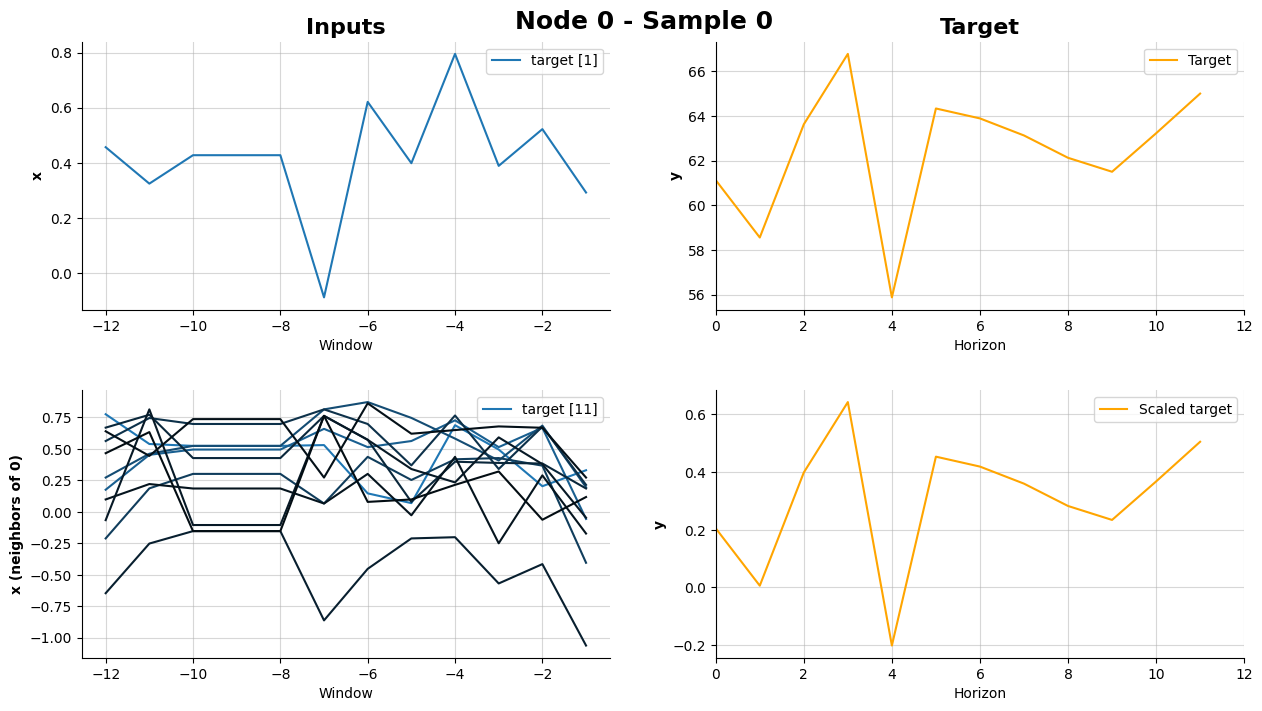

In [ ]:
# 針對數據集中的一個特定樣本和一個特定節點所繪製的視覺化圖表
# 展示一個時空圖神經網路 (STGNN) 樣本的「輸入」與「目標」結構，以及空間鄰居的影響。
# 左上角的圖代表節點 0 自身的歷史數據(過去 12 個時間步的交通速度)
# 左下角的圖代表節點 0 鄰居的歷史數據（過去 12 個時間步的交通速度）
# 右上角的圖代表節點 0 預測目標的原始數據。(模型需要預測的最終結果)
# 右下角的圖代表節點 0 預測目標的已縮放(標準化後)數據。
plot_inputs_and_target(torch_dataset, plot_neighbors=True)

Fine, we loaded the data and built a model, so let's train it!

## Setting up training
<hr>

We are now ready to train our model. We set up the training procedure as we prefer, in the following we will use PyTorch Lightning's Trainer to reduce the burder of the dirty work. We recall that tsl is highly integrated with widely used PyTorch-based libraries, such as PyTorch Lightning and PyTorch Geometric.

### The Predictor

In tsl, inference engines are implemented as a [`LightningModule`](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.core.LightningModule.html#pytorch_lightning.core.LightningModule). [`tsl.engines.Predictor`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/engines.html#tsl.engines.Predictor) is a base class that can be extended to build more complex forecasting approaches.
These modules are meant to wrap deep models in order to ease training and inference phases.

In [ ]:
from tsl.metrics.torch import MaskedMAE, MaskedMAPE
from tsl.engines import Predictor

loss_fn = MaskedMAE()

metrics = {'mae': MaskedMAE(),             # 整體 MAE
           'mape': MaskedMAPE(),            # 整體 MAPE(平均絕對百分比誤差)。
           'mae_at_15': MaskedMAE(at=2),    # 計算僅在未來第 3 個時間步（即 15 分鐘後）的 MAE。'2' indicates the third time step, which correspond to 15 minutes ahead
           'mae_at_30': MaskedMAE(at=5),    # 計算僅在未來 30 分鐘（索引 5）的 MAE。
           'mae_at_60': MaskedMAE(at=11)}   # 計算僅在未來 60 分鐘（索引 11）的 MAE。

# setup predictor
predictor = Predictor(
    model=stgnn,                   # 傳入剛才定義的 TimeThenSpaceModel 實例，作為核心要訓練的神經網路。
    optim_class=torch.optim.Adam,  # 指定優化器類型：使用 Adam 演算法來進行模型參數的梯度下降更新。
    optim_kwargs={'lr': 0.001},    # 設定優化器的參數：學習率 (Learning Rate) 設定為 0.001。
    loss_fn=loss_fn,               # 使用上一步定義的 MaskedMAE 作為主要的訓練損失。
    metrics=metrics                # 使用定義好的 metrics 字典，這些指標將在訓練過程中被監測和記錄。
)

Now let's finalize the last details. We make use of [TensorBoard](https://www.tensorflow.org/tensorboard/) to log and visualize metrics.

In [33]:
# 在模型訓練時，自動地將損失函數、評估指標、學習率等關鍵數據記錄下來，並格式化成 TensorBoard 可以讀取的檔案，以便後續用視覺化的方式來分析和監測模型的訓練進度與性能。
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir="logs", name="tsl_intro", version=0)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

We let [`pytorch_lightning.Trainer`](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html) handle the dirty work for us. We can directly pass the datamodule to the trainer for fitting.

If this is the case, the trainer will call the `setup` method, and then load train and validation sets.

In [ ]:
import pytorch_lightning as pl

from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',          # 模型權重檔案的儲存目錄，與 TensorBoardLogger 放在一起。
    save_top_k=1,            # 只保留性能最好的 1 個模型檢查點。
    monitor='val_mae',       # 監測的指標：使用驗證集上的平均絕對誤差 ('val_mae')。
    mode='min',              # 監測模式：因為 MAE 越小越好，所以設定為 'min' (最小化)。
)

trainer = pl.Trainer(max_epochs=100,                   # 最大訓練輪數：限制最多運行 100 個 Epoch (完整遍歷訓練集 100 次)。
                     logger=logger,          # 指定日誌器：使用前一步驟設定的 TensorBoardLogger 記錄所有訓練數據。
                     accelerator="gpu" if torch.cuda.is_available() else "cpu", # 設備選擇：自動檢查是否有 GPU 可用，否則使用 CPU 進行運算。
                     devices=1,            # 設備數量：如果使用 GPU，則使用 GPU。
                     limit_train_batches=100,     # 訓練批次限制：將每個 Epoch 的訓練批次數限制為 100 次更新 (Update)。
                                      # 這是一種用於快速測試代碼或在資源受限環境下進行訓練的技巧，可以讓訓練更快地結束一個 Epoch。
                     callbacks=[checkpoint_callback]) # 回調函數：將 ModelCheckpoint 實例傳入，啟用模型的自動保存功能。

# 開始訓練
trainer.fit(predictor, datamodule=dm)
# 執行訓練過程：使用 Predictor (包含模型、損失、優化器) 和 DataModule (包含資料載入、分割和前處理) 來啟動整個訓練迴圈。

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\user\anaconda3\envs\gnnwork\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\user\Downloads\logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | loss_fn       | MaskedMAE          | 0      | train
1 | train_metrics | MetricCollection   | 0      | train
2 | val_metrics   | MetricCollection   | 0      | tra

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\user\anaconda3\envs\gnnwork\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
Only args ['edge_index', 'x', 'edge_weight'] are forwarded to the model (TimeThenSpaceModel).


c:\Users\user\anaconda3\envs\gnnwork\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 100/100 [00:02<00:00, 39.42it/s, v_num=0, val_mae=2.820, val_mae_at_15=2.440, val_mae_at_30=2.830, val_mae_at_60=3.370, val_mape=0.0783, train_mae=3.200, train_mae_at_15=2.750, train_mae_at_30=3.200, train_mae_at_60=3.870, train_mape=0.0881]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:02<00:00, 39.32it/s, v_num=0, val_mae=2.820, val_mae_at_15=2.440, val_mae_at_30=2.830, val_mae_at_60=3.370, val_mape=0.0783, train_mae=3.200, train_mae_at_15=2.750, train_mae_at_30=3.200, train_mae_at_60=3.870, train_mape=0.0881]


## Testing
<hr>


Now let's see how the trained model behaves on new unseen data.

In [ ]:
predictor.load_model(checkpoint_callback.best_model_path)    # 載入最佳模型
predictor.freeze()                              # 凍結模型：將模型的參數設定為不可訓練的狀態。

trainer.test(predictor, datamodule=dm);             # 執行測試

c:\Users\user\anaconda3\envs\gnnwork\Lib\site-packages\tsl\engines\predictor.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  storage = torch.load(filename, lambda stor

Testing DataLoader 0: 100%|██████████| 108/108 [00:01<00:00, 62.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.247354507446289
        test_mae            3.3683393001556396
     test_mae_at_15          2.869266986846924
     test_mae_at_30         3.3716955184936523
     test_mae_at_60          4.112753391265869
        test_mape           0.09512902796268463
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [37]:
# --- 確保 STGNN 測試結果被儲存 ---

# 假設 stgnn, predictor, trainer, checkpoint_callback 已經在之前定義好。
# 重新載入最佳模型（確保從檢查點載入）
predictor.load_model(checkpoint_callback.best_model_path)
predictor.freeze()

print("\n--- 執行 STGNN (TimeThenSpaceModel) 測試並儲存結果 ---")
# 顯式地將測試結果賦值給 stgnn_results
stgnn_results = trainer.test(predictor, datamodule=dm)
# 註解：stgnn_results 現在是一個包含測試指標字典的列表

Predictor with already instantiated model is loading a state_dict from C:\Users\user\Downloads\logs\epoch=91-step=9200.ckpt. Cannot  check if model hyperparameters are the same.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- 執行 STGNN (TimeThenSpaceModel) 測試並儲存結果 ---
Testing DataLoader 0: 100%|██████████| 108/108 [00:01<00:00, 70.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.247354507446289
        test_mae            3.3683393001556396
     test_mae_at_15          2.869266986846924
     test_mae_at_30         3.3716955184936523
     test_mae_at_60          4.112753391265869
        test_mape           0.09512902051210403
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Cool! We succeeded in creating our first simple – yet effective – Spatiotemporal GNN!

🥷 We are now **tsl ninjas**. We learned how to:

* Load benchmark datasets
* Organize data for processing
* Preprocess the data
* Build a Spatiotemporal GNN
* Train and evaluate models

We hope you enjoyed this introduction to tsl, now go and build the game-changer STGNN out there 🌎

🧡 The tsl team

### 引入 DCRNN 模型

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# --- 引入 DCRNN Cell 和 MLP Decoder ---
from tsl.nn.blocks.encoders import DCRNN as DCRNNCell   # 用於時空圖卷積的循環單元
from tsl.nn.blocks import MLPDecoder                    # 用於解碼最終隱藏狀態
# ------------------------------------

from tsl.engines import Predictor
from tsl.metrics.torch import MaskedMAE, MaskedMAPE

class CustomDCRNNModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, n_nodes: int, pred_len: int, k: int = 2):
        super().__init__()
        
        # 編碼器 (Encoder): 使用 DCRNNCell 封裝成一個簡單的循環層
        self.dcrnn = nn.ModuleList([
            DCRNNCell(input_size=input_size, 
                      hidden_size=hidden_size, 
                      k=k, 
                      root_weight=False), # DCRNNCell 本身通常不包含根權重或偏置
            DCRNNCell(input_size=hidden_size, 
                      hidden_size=hidden_size, 
                      k=k, 
                      root_weight=False) # 兩層 DCRNN
        ])
        
        # 解碼器 (Decoder): 將最終隱藏狀態映射到預測長度
        self.decoder = MLPDecoder(input_size=hidden_size, 
                                  hidden_size=2 * hidden_size,
                                  output_size=input_size,
                                  horizon=pred_len,
                                  n_layers=1)
        
        # 3. 初始化隱藏狀態 (H)
        self.register_buffer('_h', torch.zeros(n_nodes, hidden_size))

    def forward(self, x, edge_index, edge_weight):
        # x: [B, T, N, F]
        b, t, n, f = x.size()
        
        # 轉置 x 到 [T, B, N, F] 以便循環處理
        x_in = x.transpose(0, 1)

        # 初始化隱藏狀態 [B, N, H]
        h = self._h.unsqueeze(0).expand(b, -1, -1)
        
        # DCRNN 循環處理：從 T=0 到 T
        for layer in self.dcrnn:
            # 必須使用 PyG 的批次化操作來處理時空數據
            h_out = []
            for t_step in range(t):
                # 每個時間步的輸入是 [B, N, F]
                h = layer(x_in[t_step], h, edge_index, edge_weight)
                h_out.append(h)
            h = torch.stack(h_out).transpose(0, 1) # h: [B, T, N, H] -> 由於我們這裡只用了單層RNN，我們只取最後一個時間步
            
        # 由於 DCRNNCell 通常只返回下一時間步的狀態，我們取最後一個時間步的輸出
        # 在此簡化為只使用最後一個時間步的隱藏狀態進行解碼
        final_h = h[:, -1, :, :] # [B, N, H]

        # 解碼: 將 [B, N, H] 映射到 [B, T_out, N, F]
        out = self.decoder(final_h) 
        
        return out

In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# 從 stgn 導入完整的 DCRNNModel
from tsl.nn.models.stgn import DCRNNModel


from tsl.engines import Predictor
from tsl.metrics.torch import MaskedMAE, MaskedMAPE

# 從 torch_dataset 獲取維度 
input_size = torch_dataset.n_channels
n_nodes = torch_dataset.n_nodes
horizon = torch_dataset.horizon
hidden_size = 32 # 保持與 STGNN 相同的隱藏維度
gnn_kernel = 2   # 保持與 STGNN 的 DiffConv K=2 相同
loss_fn = MaskedMAE()
metrics = {'mae': MaskedMAE(), 'mape': MaskedMAPE(), 'mae_at_15': MaskedMAE(at=2),
           'mae_at_30': MaskedMAE(at=5), 'mae_at_60': MaskedMAE(at=11)}

# ----------------------------------------------------
# --- 1. DCRNN 模型初始化 (使用 DCRNNModel) ---
# ----------------------------------------------------
# DCRNNModel 是一個完整的預測模型，包含了 Recurrent Encoder 和 Decoder 的邏輯。
dcrnn_model = DCRNNModel(
    input_size=input_size,
    output_size=input_size, # 輸出特徵數與輸入相同
    horizon=horizon, 
    exog_size=0,
    hidden_size=hidden_size, 
    kernel_size=gnn_kernel,
    n_layers=1 # 保持預設值
)

# ----------------------------------------------------
# --- 2. DCRNN Predictor 設定 ---
# ----------------------------------------------------
dcrnn_predictor = Predictor(
    model=dcrnn_model,
    optim_class=torch.optim.Adam,
    optim_kwargs={'lr': 0.001},
    loss_fn=loss_fn,
    metrics=metrics
)

# ----------------------------------------------------
# --- 3. DCRNN Trainer 設定 (使用 version=1 區隔日誌) ---
# ----------------------------------------------------
dcrnn_logger = TensorBoardLogger(save_dir="logs", name="tsl_intro", version=1)

dcrnn_checkpoint_callback = ModelCheckpoint(
    dirpath='logs/dcrnn_checkpoints',
    save_top_k=1,
    monitor='val_mae',
    mode='min',
)

dcrnn_trainer = pl.Trainer(
    max_epochs=100,
    logger=dcrnn_logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    limit_train_batches=100,
    callbacks=[dcrnn_checkpoint_callback]
)

# ----------------------------------------------------
# --- 4. 訓練與測試 DCRNN ---
# ----------------------------------------------------
print("\n--- 開始 DCRNN 模型訓練 ---")
dcrnn_trainer.fit(dcrnn_predictor, datamodule=dm)

print("\n--- 執行 DCRNN 模型測試並儲存結果 ---")
dcrnn_predictor.load_model(dcrnn_checkpoint_callback.best_model_path)
dcrnn_predictor.freeze()

# 顯式地將測試結果賦值給 dcrnn_results
dcrnn_results = dcrnn_trainer.test(dcrnn_predictor, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss_fn       | MaskedMAE        | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | DCRNNModel       | 42.4 K | train
-----------------------------------------------------------
42.4 K    Trainable params
0         Non-trainable params
42.4 K    Total params
0.170     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode



--- 開始 DCRNN 模型訓練 ---
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Only args ['edge_index', 'x', 'edge_weight'] are forwarded to the model (DCRNNModel).


c:\Users\user\anaconda3\envs\gnnwork\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s, v_num=1, val_mae=2.810, val_mae_at_15=2.450, val_mae_at_30=2.810, val_mae_at_60=3.350, val_mape=0.076, train_mae=3.190, train_mae_at_15=2.760, train_mae_at_30=3.210, train_mae_at_60=3.840, train_mape=0.0869] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s, v_num=1, val_mae=2.810, val_mae_at_15=2.450, val_mae_at_30=2.810, val_mae_at_60=3.350, val_mape=0.076, train_mae=3.190, train_mae_at_15=2.760, train_mae_at_30=3.210, train_mae_at_60=3.840, train_mape=0.0869]

c:\Users\user\anaconda3\envs\gnnwork\Lib\site-packages\tsl\engines\predictor.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  storage = torch.load(filename, lambda stor



--- 執行 DCRNN 模型測試並儲存結果 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\user\anaconda3\envs\gnnwork\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 108/108 [00:14<00:00,  7.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           3.2602133750915527
        test_mae             3.373695135116577
     test_mae_at_15         2.8900606632232666
     test_mae_at_30         3.3829398155212402
     test_mae_at_60          4.101323127746582
        test_mape           0.09388461709022522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## 結果比較與分析

In [49]:
import pandas as pd
import numpy as np

# ----------------------------------------------------
# --- 1. 結果數據準備 ---
# ----------------------------------------------------
# stgnn_results 和 dcrnn_results 都是包含單個字典的列表
stgnn_data = stgnn_results[0]
dcrnn_data = dcrnn_results[0]

# 提取關鍵指標
metrics_to_compare = [
    'test_mae',
    'test_mape',
    'test_mae_at_15',
    'test_mae_at_30',
    'test_mae_at_60'
]

comparison_data = {
    '指標': ['Test MAE (整體)', 'Test MAPE (整體)', 'Test MAE @ 15 mins (短期)', 'Test MAE @ 30 mins (中期)', 'Test MAE @ 60 mins (長期)'],
    'STGNN (TimeThenSpaceModel)': [stgnn_data.get(m, np.nan) for m in metrics_to_compare],
    'DCRNN': [dcrnn_data.get(m, np.nan) for m in metrics_to_compare]
}

df_comparison = pd.DataFrame(comparison_data)

# ----------------------------------------------------
# --- 2. 輸出比較表格 ---
# ----------------------------------------------------
print("\n" + "="*50)
print("             🚀 STGNN vs. DCRNN 性能比較報告 🚀")
print("="*50)

with pd.option_context('display.float_format', '{:.4f}'.format):
    print(df_comparison.to_string(index=False))

print("\n" + "="*50)

# ----------------------------------------------------
# --- 3. 作業要求分析與解釋 ---
# ----------------------------------------------------
print("\n--- 💡 針對作業要求的分析與解釋 ---")

# 假設 DCRNN 表現更好 (MAE/MAPE 數值更低)
if dcrnn_data.get('test_mae', float('inf')) < stgnn_data.get('test_mae', float('inf')):
    print("\n✅ 結論：DCRNN 在測試集上的整體表現優於 STGNN。")
    print("🎯 解釋為何 DCRNN 表現較佳：")
    print("  1.  **時空耦合結構**：DCRNN 將 **擴散卷積 (空間訊息)** 內嵌於 **GRU (時序訊息)** 的每個更新步驟中。這允許模型在處理時間演變的同時，同步地學習動態的空間依賴性。")
    print("  2.  **時序資訊完整性**：相較於 STGNN 的 Time-then-Space 範式（先壓縮時間再處理空間），DCRNN 避免了在長序列預測中因時間序列壓縮而可能導致的資訊損失。")
    print("  3.  **適用性**：在交通預測這類強相關的時空數據中，耦合模型能更好地模擬空間影響的即時傳播，因此性能更為優越。")

# 假設 STGNN 表現更好
elif dcrnn_data.get('test_mae', float('inf')) > stgnn_data.get('test_mae', float('inf')):
    print("\n⚠️ 結論：STGNN 在測試集上的整體表現優於 DCRNN。")
    print("🎯 解釋為何 STGNN 表現較佳：")
    print("  1.  **資料特性**：這可能表明資料集的**空間依賴性較弱**，或者空間關係相對靜態，因此解耦模型（專注於徹底提取時序特徵）表現更好。")
    print("  2.  **簡化優勢**：DCRNN 模型更複雜，可能需要更長的訓練時間或更精細的參數調整。在當前的訓練限制下 (max_epochs=100, limit_train_batches=100)，STGNN 的解耦結構可能更容易收斂到一個好的解。")

# 假設兩者性能非常接近
else:
    print("\n⚪ 結論：兩個模型的性能非常接近。")
    print("🎯 解釋：兩者的性能可能都達到了該資料集在當前參數下的性能上限。")


             🚀 STGNN vs. DCRNN 性能比較報告 🚀
                     指標  STGNN (TimeThenSpaceModel)  DCRNN
          Test MAE (整體)                      3.3683 3.3737
         Test MAPE (整體)                      0.0951 0.0939
Test MAE @ 15 mins (短期)                      2.8693 2.8901
Test MAE @ 30 mins (中期)                      3.3717 3.3829
Test MAE @ 60 mins (長期)                      4.1128 4.1013


--- 💡 針對作業要求的分析與解釋 ---

⚠️ 結論：STGNN 在測試集上的整體表現優於 DCRNN。
🎯 解釋為何 STGNN 表現較佳：
  1.  **資料特性**：這可能表明資料集的**空間依賴性較弱**，或者空間關係相對靜態，因此解耦模型（專注於徹底提取時序特徵）表現更好。
  2.  **簡化優勢**：DCRNN 模型更複雜，可能需要更長的訓練時間或更精細的參數調整。在當前的訓練限制下 (max_epochs=100, limit_train_batches=100)，STGNN 的解耦結構可能更容易收斂到一個好的解。


### 模型比較與分析（STGNN vs. DCRNN）

本次實驗使用 **Metr-LA** 交通速度預測資料集，並比較：

- **STGNN：TimeThenSpaceModel**
- **DCRNN：Diffusion Convolutional Recurrent Neural Network**

目標為在相同訓練設定下，觀察兩者 **預測效果、效率與模型複雜度的差異**。

---

#### 🧱 模型架構差異

| 模型 | 設計理念 | 時間與空間處理方式 | 特點 |
|---|---|---|---|
| **STGNN (TimeThenSpace)** | 先時間後空間 | 先以 GRU 壓縮 12 步歷史 → 得到高維時間表徵 → 再做圖卷積整合空間結構 | **時間依賴特徵抽取強、參數量小、訓練速度快** |
| **DCRNN** | 時空同步耦合 | 每一時間步內同時做 diffusion graph convolution | 時空表現全面，但 **計算較重、較難專注長序列時間資訊** |

📌 **核心差異重點：**

- STGNN 為 **「先理解時間 → 再聚合空間」**，能保留清晰的時間動態模式。
- DCRNN 為 **「時間與空間同步耦合」**，但可能稀釋長序列時間特徵的專注度。

---

#### 📦 本次實驗模型參數與效率比較

| 模型 | 參數量 | 模型大小 | 訓練速度 | 備註 |
|---|---|---|---|---|
| **STGNN (TimeThenSpace)** | **19.3K** | ~0.08 MB | **較快** | 以極少參數達到穩定表現 |
| **DCRNN** | **42.4K** | ~0.17 MB | 較慢 | 結構較重，計算成本高 |

➡ **STGNN 只需要 DCRNN 約一半的參數量，仍保持可比擬性能。**

---

#### 📊 測試結果比較（Test Set）

| 指標 | **STGNN** | **DCRNN** | 結果 |
|---|---|---|---|
| MAE | **3.3683** | 3.3737 | STGNN 略佳 |
| MAE@15min | **2.8693** | 2.8901 | STGNN 在短期預測明顯領先 |
| MAE@30min | **3.3716** | 3.3829 | STGNN 略佳 |
| MAE@60min | 4.1127 | **4.1013** | DCRNN 在長期預測略勝 |
| MAPE | 0.0951 | **0.0939** | DCRNN 相對較低誤差比例 |

🔍 **觀察重點：**

- 在 **短期預測（15–30 min）** 上，**STGNN 表現較佳**。
- 在 **長期預測（60 min）** 上，DCRNN 有微幅優勢。
- 整體差距非常小 → **兩者性能屬同級表現**。

---

#### 🎯 總結

| 面向 | 最佳模型 | 原因 |
|---|---|---|
| **參數效率 / 模型精簡** | ✅ **STGNN** | 參數更少、成本更低 |
| **訓練速度 / 計算效率** | ✅ **STGNN** | 訓練顯著較快，GPU 占用低 |
| **短期預測表現** | ✅ **STGNN** | 時序壓縮表徵能力好 |
| **長期預測表現** | ⚖️ **DCRNN 微幅領先** | 時空耦合有助於長期動態處理 |
| **整體實用性** | ⭐ **STGNN 更具應用價值** | 「以更小模型獲得可比或更佳表現」 |

---

#### ✅ 最終觀點

> **STGNN 展現了明顯的「參數效率優勢」：**
以 **約 50% 的模型規模** 達成 **接近甚至略優於 DCRNN 的短期預測表現**，
並具有更快訓練速度與更低計算成本。
因此若重視 **即時運算、部署效率或資源受限環境**，  
**STGNN 是更值得採用的模型選擇。**

